# Resumo do Desafio - KDD Cup 2009: Customer relationship prediction
Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling).

The most practical way, in a CRM system, to build knowledge on customer is to produce scores. A score (the output of a model) is an evaluation for all instances of a target variable to explain (i.e. churn, appetency or up-selling). Tools which produce scores allow to project, on a given population, quantifiable information. The score is computed using input variables which describe instances. Scores are then used by the information system (IS), for example, to personalize the customer relationship. An industrial customer analysis platform able to build prediction models with a very large number of input variables has been developed by Orange Labs. This platform implements several processing methods for instances and variables selection, prediction and indexation based on an efficient model combined with variable selection regularization and model averaging method. The main characteristic of this platform is its ability to scale on very large datasets with hundreds of thousands of instances and thousands of variables. The rapid and robust detection of the variables that have most contributed to the output prediction can be a key factor in a marketing application.

The challenge is to beat the in-house system developed by Orange Labs. It is an opportunity to prove that you can deal with a very large database, including heterogeneous noisy data (numerical and categorical variables), and unbalanced class distributions. Time efficiency is often a crucial point. Therefore part of the competition will be time-constrained to test the ability of the participants to deliver solutions quickly.

Link: https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro

# Índice
- [Carregando as libs e os arquivos](#Carregando-as-libs-e-os-arquivos)
- [EDA](#EDA)
    - [Trazendo as labels para o dataset principal](#Trazendo-as-labels-para-o-dataset-principal)
    - [Gráficos com as features numéricas](#Gráficos-com-as-features-numéricas)
    - [Preenchendo os missing values](#Preenchendo-os-missing-values)
    - [Transformando as features categóricas em dummies](#Transformando-as-features-categóricas-em-dummies)
- [Gerando os datasets para criação dos modelos](#Gerando-os-datasets-para-criação-dos-modelos)
    - [Modelo de Appetency](#Modelo-de-Appetency)
    - [Modelo de Churn](#Modelo-de-Churn)
    - [Modelo de Upselling](#Modelo-de-Upselling)
- [Conclusão](#Conclusão)

# Carregando as libs e os arquivos

In [1]:
#-- carregando as bibliotecas
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix)
from imblearn.over_sampling import SMOTE

In [2]:
#-- listando arquivos na pasta do Office Track
arr = os.listdir('../data')
arr

['Log_ROC.png',
 'orange_small_test.data',
 'orange_small_test.data.cksum',
 'orange_small_train.data',
 'orange_small_train.data.cksum',
 'orange_small_train_churn.labels']

In [3]:
#-- extraindo os arquivos do zip
extension = ".zip"
os.chdir('../data')

for item in os.listdir('../data'):
    if item.endswith(extension):
        file_name = os.path.abspath(item)
        zip_ref = zipfile.ZipFile(file_name)
        zip_ref.extractall('../data')
        zip_ref.close()
        os.remove(file_name)

In [4]:
#-- listando arquivos na pasta do Office Track
arr = os.listdir('../data')
arr

['Log_ROC.png',
 'orange_small_test.data',
 'orange_small_test.data.cksum',
 'orange_small_train.data',
 'orange_small_train.data.cksum',
 'orange_small_train_churn.labels']

In [5]:
#-- carregando os dados de treino
db = pd.read_csv('orange_small_train.data', sep='\t')

In [6]:
#-- printando o head do dataset de treino
db.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [7]:
#-- printando as dimensões do dateset para verificar sua integridade
db.shape

(50000, 230)

# EDA

In [8]:
#-- verificando as features com mais missing values
for t in db.columns:
    #print(db.isnull().sum().sort_values(ascending=False)/len(db))
    print(t + ': ' + str(db[t].isnull().sum()/len(db)))

Var1: 0.98596
Var2: 0.97518
Var3: 0.9752
Var4: 0.96842
Var5: 0.97026
Var6: 0.11058
Var7: 0.11078
Var8: 1.0
Var9: 0.98596
Var10: 0.97026
Var11: 0.9752
Var12: 0.98884
Var13: 0.11078
Var14: 0.9752
Var15: 1.0
Var16: 0.97026
Var17: 0.96842
Var18: 0.96842
Var19: 0.96842
Var20: 1.0
Var21: 0.11058
Var22: 0.10018
Var23: 0.97026
Var24: 0.1446
Var25: 0.10018
Var26: 0.97026
Var27: 0.97026
Var28: 0.10022
Var29: 0.98596
Var30: 0.98596
Var31: 1.0
Var32: 1.0
Var33: 0.98306
Var34: 0.97518
Var35: 0.10018
Var36: 0.97518
Var37: 0.96842
Var38: 0.10018
Var39: 1.0
Var40: 0.97518
Var41: 0.98596
Var42: 1.0
Var43: 0.97518
Var44: 0.10018
Var45: 0.99312
Var46: 0.97518
Var47: 0.98596
Var48: 1.0
Var49: 0.97518
Var50: 0.98596
Var51: 0.92506
Var52: 1.0
Var53: 0.98596
Var54: 0.97518
Var55: 1.0
Var56: 0.98708
Var57: 0.0
Var58: 0.98596
Var59: 0.9836
Var60: 0.97026
Var61: 0.98306
Var62: 0.98884
Var63: 0.98612
Var64: 0.99524
Var65: 0.11078
Var66: 0.98612
Var67: 0.97026
Var68: 0.97518
Var69: 0.97026
Var70: 0.97026
Var71: 0

> Existem algumas features com missing values acima de 90%, por isso irei printar a quantidade de colunas com missing values variando sua a porcentagem 

In [9]:
#-- printando a quantidade de colunas com missing values variando sua a porcentagem
for i in range(10, 105, 5):
    print(str(i) + '%: ' + str(((db.isnull().sum()/len(db))*100 >= i).sum()))

10%: 202
15%: 164
20%: 164
25%: 164
30%: 163
35%: 163
40%: 163
45%: 161
50%: 161
55%: 158
60%: 156
65%: 156
70%: 156
75%: 154
80%: 154
85%: 154
90%: 154
95%: 153
100%: 18


> Irei assumir missing values até 15% como aceitável. As colunas que restarem com missing values irei tratá-las posteriormente.

In [10]:
#-- copiando o nome das colunas que serão mantidas. Essas colunas tem até 15% de missing value
lista_columns_not_drop = ((db.isnull().sum()/len(db)) < 0.15).values

In [11]:
#-- filtrando o dataset original com as colunas que contém até 15% de missing value
db_dcol = db.loc[:,lista_columns_not_drop]

In [12]:
#-- verificando a quantidade de colunas removidas, nenhuma linha deve ser removida
db_dcol.shape

(50000, 66)

In [13]:
#-- printando o head do novo dataset
db_dcol.head().T

,0,1,2,3,4
Var6,1526,525,5236,NaN,1029
Var7,7,0,7,0,7
Var13,184,0,904,0,3216
Var21,464,168,1212,NaN,64
Var22,580,210,1515,0,80
...,...,...,...,...,...
Var222,fXVEsaq,2Kb5FSF,NKv4yOc,CE7uk3u,1J2cvxe
Var223,jySVZNlOJy,LM8l689qOp,jySVZNlOJy,LM8l689qOp,LM8l689qOp
Var226,xb3V,fKCe,Qu4f,FSa2,FSa2
Var227,RAYp,RAYp,02N6s8f,RAYp,RAYp


In [14]:
#-- printando o tipo das colunas
db_dcol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Var6    44471 non-null  float64
 1   Var7    44461 non-null  float64
 2   Var13   44461 non-null  float64
 3   Var21   44471 non-null  float64
 4   Var22   44991 non-null  float64
 5   Var24   42770 non-null  float64
 6   Var25   44991 non-null  float64
 7   Var28   44989 non-null  float64
 8   Var35   44991 non-null  float64
 9   Var38   44991 non-null  float64
 10  Var44   44991 non-null  float64
 11  Var57   50000 non-null  float64
 12  Var65   44461 non-null  float64
 13  Var73   50000 non-null  int64  
 14  Var74   44461 non-null  float64
 15  Var76   44991 non-null  float64
 16  Var78   44991 non-null  float64
 17  Var81   44471 non-null  float64
 18  Var83   44991 non-null  float64
 19  Var85   44991 non-null  float64
 20  Var109  42770 non-null  float64
 21  Var112  44991 non-null  float64
 22

In [15]:
#-- printando algumas métricas das colunas numéricas
db_dcol.describe().T

,count,mean,std,min,25%,50%,75%,max
Var6,44471.0,1.326437e+03,2.685694e+03,0.000000e+00,5.180000e+02,8.610000e+02,1.428000e+03,131761.00
Var7,44461.0,6.809496e+00,6.326053e+00,0.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,140.00
Var13,44461.0,1.249688e+03,2.794955e+03,0.000000e+00,0.000000e+00,2.320000e+02,1.604000e+03,197872.00
Var21,44471.0,2.345182e+02,5.655601e+02,0.000000e+00,1.120000e+02,1.440000e+02,2.280000e+02,36272.00
Var22,44991.0,2.902454e+02,7.044900e+02,0.000000e+00,1.350000e+02,1.800000e+02,2.850000e+02,45340.00
Var24,42770.0,4.507926e+00,9.928819e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,494.00
Var25,44991.0,9.682701e+01,2.143183e+02,0.000000e+00,1.600000e+01,4.800000e+01,1.120000e+02,13168.00
Var28,44989.0,2.245077e+02,9.852024e+01,-6.688000e+01,1.665600e+02,2.200800e+02,2.664000e+02,5158.56
Var35,44991.0,7.168100e-01,2.996007e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,110.00
Var38,44991.0,2.579107e+06,3.010076e+06,0.000000e+00,7.794000e+03,1.290246e+06,4.570944e+06,18846900.00


> Analisando a média, o desvio padrão e os quartis das features é possível perceber valores com ordem de grandeza distintos. Dependendo do algoritmo a ser utilizado, precisarei **padronizar os dados**.

In [16]:
#-- criando uma array com as colunas numéricas
columns_numeric = db_dcol.select_dtypes(include=['float','int64']).columns
columns_numeric = np.array(columns_numeric)
columns_numeric

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181'], dtype=object)

In [17]:
#-- printando a quantidade de dados numéricos possíveis em cada uma das colunas e a porcentagem de missing values
for i in columns_numeric:
    print('Valores ' + i + ': ' + str(len(db_dcol[i].value_counts()))) #-- quantidade de variações categóricas
    print('Missing Value ' + i + ': ' + str(round(db_dcol[i].isnull().sum()/len(db_dcol)*100,2)) + '%') #-- quantidade de missing value %
    print('\n')

Valores Var6: 1486
Missing Value Var6: 11.06%


Valores Var7: 8
Missing Value Var7: 11.08%


Valores Var13: 2634
Missing Value Var13: 11.08%


Valores Var21: 734
Missing Value Var21: 11.06%


Valores Var22: 735
Missing Value Var22: 10.02%


Valores Var24: 93
Missing Value Var24: 14.46%


Valores Var25: 271
Missing Value Var25: 10.02%


Valores Var28: 4167
Missing Value Var28: 10.02%


Valores Var35: 13
Missing Value Var35: 10.02%


Valores Var38: 30832
Missing Value Var38: 10.02%


Valores Var44: 8
Missing Value Var44: 10.02%


Valores Var57: 25614
Missing Value Var57: 0.0%


Valores Var65: 15
Missing Value Var65: 11.08%


Valores Var73: 131
Missing Value Var73: 0.0%


Valores Var74: 371
Missing Value Var74: 11.08%


Valores Var76: 29743
Missing Value Var76: 10.02%


Valores Var78: 13
Missing Value Var78: 10.02%


Valores Var81: 43042
Missing Value Var81: 11.06%


Valores Var83: 195
Missing Value Var83: 10.02%


Valores Var85: 149
Missing Value Var85: 10.02%


Valores Var109: 209
Missi

> Algumas features numéricas poderiam até ser variáveis categóricas como: Var7 e Var44. Por enquanto, irei tratá-las como numéricas mesmo.

In [18]:
#-- criando uma array com as colunas não numéricas
columns_object = db_dcol.select_dtypes(object).columns
columns_object = np.array(columns_object)
columns_object

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206',
       'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216',
       'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222',
       'Var223', 'Var226', 'Var227', 'Var228'], dtype=object)

In [19]:
#-- printando a quantidade de dados categóricos possíveis em cada uma das colunas e a porcentagem de missing values
for i in columns_object:
    print('Categórico ' + i + ': ' + str(len(db_dcol[i].value_counts()))) #-- quantidade de variações categóricas
    print('Missing Value ' + i + ': ' + str(round(db_dcol[i].isnull().sum()/len(db_dcol)*100,2)) + '%') #-- quantidade de missing value %
    print('\n')

Categórico Var192: 361
Missing Value Var192: 0.74%


Categórico Var193: 51
Missing Value Var193: 0.0%


Categórico Var195: 23
Missing Value Var195: 0.0%


Categórico Var196: 4
Missing Value Var196: 0.0%


Categórico Var197: 225
Missing Value Var197: 0.29%


Categórico Var198: 4291
Missing Value Var198: 0.0%


Categórico Var199: 5073
Missing Value Var199: 0.01%


Categórico Var202: 5713
Missing Value Var202: 0.0%


Categórico Var203: 5
Missing Value Var203: 0.29%


Categórico Var204: 100
Missing Value Var204: 0.0%


Categórico Var205: 3
Missing Value Var205: 3.87%


Categórico Var206: 21
Missing Value Var206: 11.06%


Categórico Var207: 14
Missing Value Var207: 0.0%


Categórico Var208: 2
Missing Value Var208: 0.29%


Categórico Var210: 6
Missing Value Var210: 0.0%


Categórico Var211: 2
Missing Value Var211: 0.0%


Categórico Var212: 81
Missing Value Var212: 0.0%


Categórico Var216: 2016
Missing Value Var216: 0.0%


Categórico Var217: 13990
Missing Value Var217: 1.41%


Categórico Var

> Algumas features não numéricas possuem diversos valores categóricos, como não conheço os dados e eles ainda estão codificados, irei dropar as features com mais de 1000 valores categóricos.

In [20]:
#-- dropando as features não numéricas com mais de 1000 valores categóricos possíveis
db_dcol_dcat = db_dcol.drop(columns=['Var198', 'Var199', 'Var202', 'Var216', 'Var217', 'Var220', 'Var222'])

## Trazendo as labels para o dataset principal

In [21]:
#-- criando a db para a label churn
label_churn = pd.read_csv('orange_small_train_churn.labels', header=None)
label_churn = pd.DataFrame(label_churn)
label_churn.head()

,0
0,-1
1,1
2,-1
3,-1
4,-1


In [22]:
#-- verificando os valores possíveis para a label churn
label_churn[0].value_counts()

-1    46328
 1     3672
Name: 0, dtype: int64

In [23]:
#-- copiando a db de label churn para o dataset db_dloc
db_dcol_dcat.loc[:,'label_churn'] = label_churn.iloc[:,0]
db_dcol_dcat.head().T

,0,1,2,3,4
Var6,1526,525,5236,NaN,1029
Var7,7,0,7,0,7
Var13,184,0,904,0,3216
Var21,464,168,1212,NaN,64
Var22,580,210,1515,0,80
Var24,14,2,26,NaN,4
Var25,128,24,816,0,64
Var28,166.56,353.52,220.08,22.08,200
Var35,0,0,0,0,0
Var38,3570,4.76497e+06,5.88389e+06,0,0


In [24]:
#-- criando a db para a label upselling
label_upselling = pd.read_csv('https://www.kdd.org/cupfiles/KDDCupData/2009/orange_small_train_upselling.labels', header=None)
label_upselling = pd.DataFrame(label_upselling)
label_upselling.head()

,0
0,-1
1,-1
2,-1
3,-1
4,-1


In [25]:
#-- verificando os valores possíveis para a label upselling
label_upselling[0].value_counts()

-1    46318
 1     3682
Name: 0, dtype: int64

In [26]:
#-- copiando a db de label churn para o dataset db_dloc
db_dcol_dcat.loc[:,'label_upselling'] = label_upselling.iloc[:,0]
db_dcol_dcat.head().T

,0,1,2,3,4
Var6,1526,525,5236,NaN,1029
Var7,7,0,7,0,7
Var13,184,0,904,0,3216
Var21,464,168,1212,NaN,64
Var22,580,210,1515,0,80
...,...,...,...,...,...
Var226,xb3V,fKCe,Qu4f,FSa2,FSa2
Var227,RAYp,RAYp,02N6s8f,RAYp,RAYp
Var228,F2FyR07IdsN7I,F2FyR07IdsN7I,ib5G6X1eUxUn6,F2FyR07IdsN7I,F2FyR07IdsN7I
label_churn,-1,1,-1,-1,-1


In [27]:
#-- criando a db para a label appetency
label_appetency = pd.read_csv('https://www.kdd.org/cupfiles/KDDCupData/2009/orange_small_train_appetency.labels', header=None)
label_appetency = pd.DataFrame(label_appetency)
label_appetency.head()

,0
0,-1
1,-1
2,-1
3,-1
4,-1


In [28]:
#-- verificando os valores possíveis para a label appetency
label_appetency[0].value_counts()

-1    49110
 1      890
Name: 0, dtype: int64

In [29]:
#-- copiando a db de label churn para o dataset db_dloc
db_dcol_dcat.loc[:,'label_appetency'] = label_appetency.iloc[:,0]
db_dcol_dcat.head().T

,0,1,2,3,4
Var6,1526,525,5236,NaN,1029
Var7,7,0,7,0,7
Var13,184,0,904,0,3216
Var21,464,168,1212,NaN,64
Var22,580,210,1515,0,80
...,...,...,...,...,...
Var227,RAYp,RAYp,02N6s8f,RAYp,RAYp
Var228,F2FyR07IdsN7I,F2FyR07IdsN7I,ib5G6X1eUxUn6,F2FyR07IdsN7I,F2FyR07IdsN7I
label_churn,-1,1,-1,-1,-1
label_upselling,-1,-1,-1,-1,-1


> Printando os valores possíveis das labels, nota-se que as labels estão desbalanceadas. Existe 90% de casos negativos e apenas 10% de casos positivos (ou até menos). Precisarei tratar esse ponto antes de aplicar um algoritmo.

In [30]:
#-- copiando o dataset
db_dcol_drow = db_dcol_dcat.copy()

In [31]:
#-- verificando quantas linhas foram removidas do dataset
db_dcol_drow.shape

(50000, 62)

## Gráficos com as features numéricas

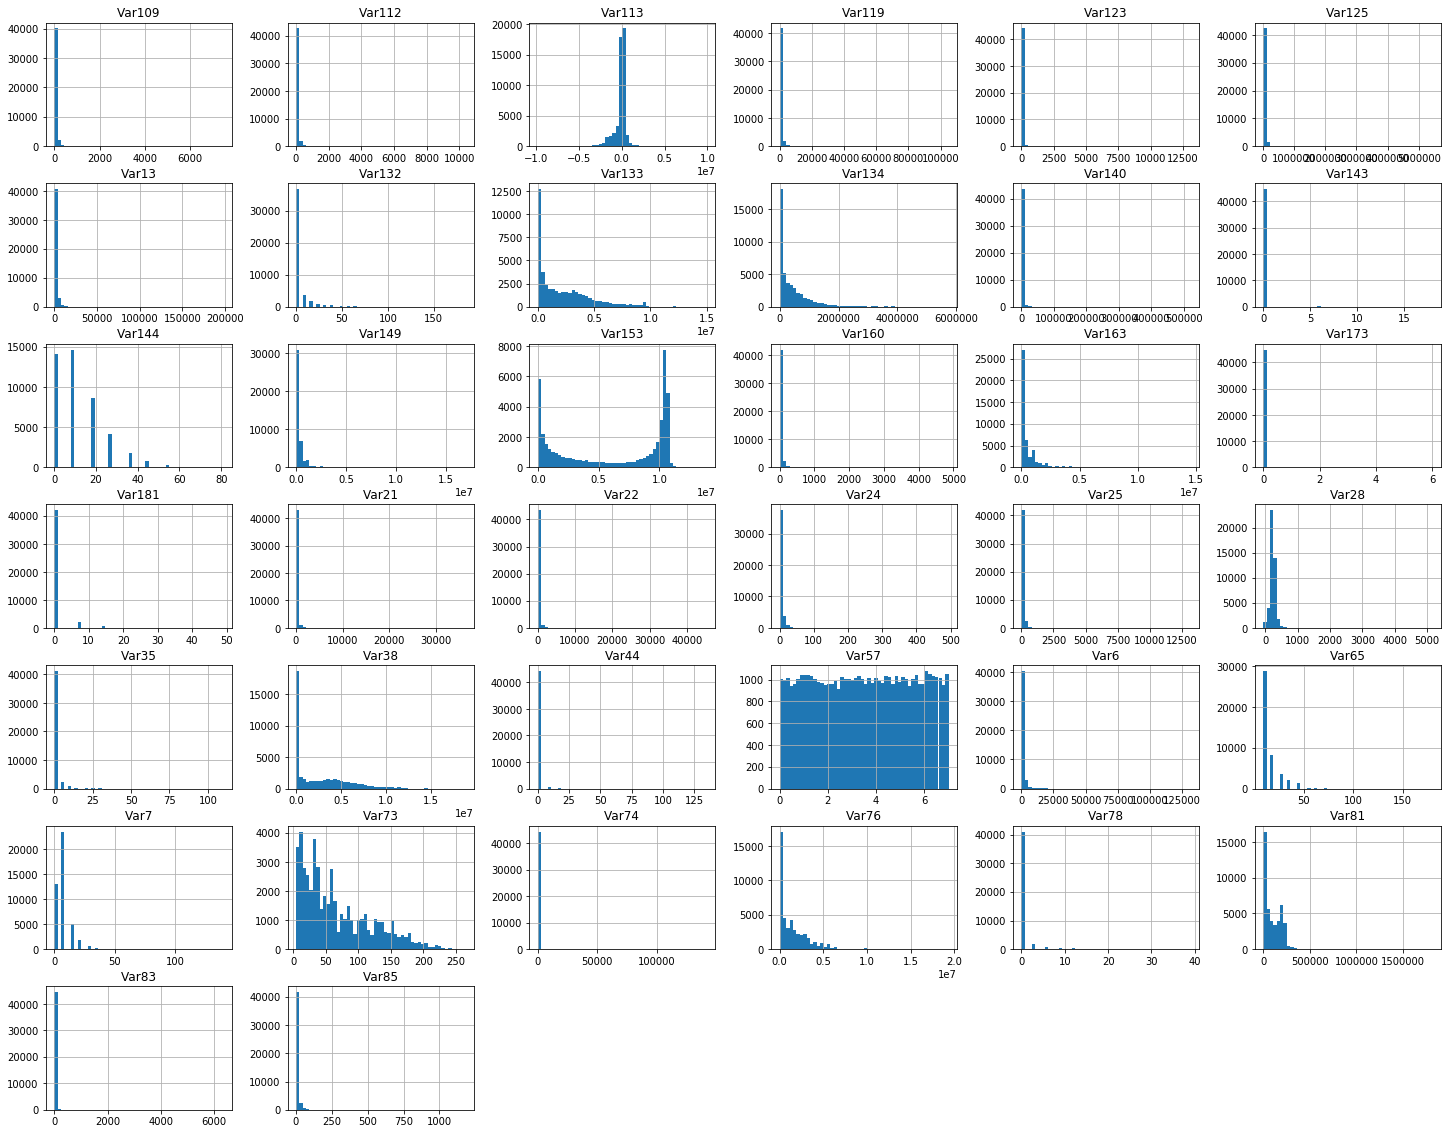

In [32]:
#-- plotando um histograma para cada feature numérica
_ = db_dcol_drow[columns_numeric].hist(bins=50, figsize=(25,20))

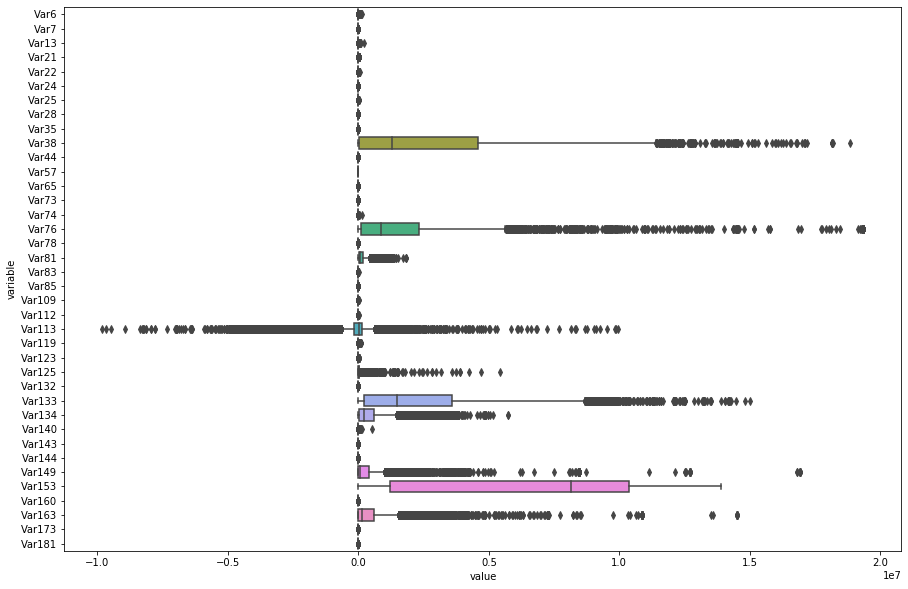

In [33]:
#-- plotando um boxplot para as features numéricas
plt.figure(figsize=(15,10))
_ = sns.boxplot(x="value", y="variable", data=db_dcol_drow[columns_numeric].melt())

## Preenchendo os missing values

In [34]:
#-- preenchendo as features numéricas com missing value - usando a mediana para isso
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(db_dcol_drow.loc[:, columns_numeric])
db_dcol_drow.loc[:, columns_numeric] = imputer.transform(db_dcol_drow.loc[:, columns_numeric])

In [35]:
#-- verificando se as features numéricas não tem mais nenhum missing value
x_null = db_dcol_drow[columns_numeric].isnull()
null_data = pd.DataFrame({
    "count": x_null.sum(),
    "mean": x_null.mean()
})
null_data

,count,mean
Var6,0,0.0
Var7,0,0.0
Var13,0,0.0
Var21,0,0.0
Var22,0,0.0
Var24,0,0.0
Var25,0,0.0
Var28,0,0.0
Var35,0,0.0
Var38,0,0.0


In [36]:
#-- criando uma análise de correlação
corr = db_dcol_drow[columns_numeric].corr()

In [37]:
#-- printando o resultado da correlação
corr

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181
Var6,1.000000,0.149707,0.100771,0.578261,0.577376,0.424690,0.508175,-0.012220,-0.001175,0.029707,...,0.022977,0.063193,-0.005168,0.093685,0.013538,0.030095,0.504057,0.023826,-0.001626,-0.013717
Var7,0.149707,1.000000,0.402145,0.064835,0.067342,0.074811,0.079414,-0.022736,-0.015353,0.018794,...,0.034540,0.268847,-0.011877,0.315327,0.011594,0.051056,0.062789,0.020716,-0.003836,-0.052227
Var13,0.100771,0.402145,1.000000,0.054268,0.054999,0.047019,0.054193,0.004956,0.018836,0.024806,...,0.042448,0.258948,0.005314,0.293658,0.027946,0.025665,0.057647,0.033340,0.003655,-0.008670
Var21,0.578261,0.064835,0.054268,1.000000,0.998188,0.672756,0.885292,-0.005510,0.035728,0.023137,...,0.020470,0.031961,-0.000703,0.022412,0.006055,0.012934,0.925193,0.015655,-0.000020,-0.005182
Var22,0.577376,0.067342,0.054999,0.998188,1.000000,0.676850,0.886386,-0.001403,0.036156,0.025046,...,0.022016,0.032586,-0.000677,0.022834,0.006905,0.016424,0.927466,0.016966,0.000085,-0.008545
Var24,0.424690,0.074811,0.047019,0.672756,0.676850,1.000000,0.662359,-0.056254,0.018229,-0.094454,...,-0.016903,0.038273,0.001637,0.009465,0.091018,-0.127450,0.578759,0.007854,0.001712,0.000071
Var25,0.508175,0.079414,0.054193,0.885292,0.886386,0.662359,1.000000,-0.042271,0.031616,-0.069216,...,0.071195,0.041710,-0.002416,0.009922,0.008659,-0.086117,0.791262,0.044729,-0.001883,-0.002479
Var28,-0.012220,-0.022736,0.004956,-0.005510,-0.001403,-0.056254,-0.042271,1.000000,0.083329,0.271178,...,0.163431,0.022879,0.039437,0.083163,0.064216,0.362663,-0.010198,0.123044,-0.007753,-0.004532
Var35,-0.001175,-0.015353,0.018836,0.035728,0.036156,0.018229,0.031616,0.083329,1.000000,0.065145,...,0.028469,0.022290,0.087240,0.028722,0.015322,0.043870,0.034126,0.030127,0.049758,0.070961
Var38,0.029707,0.018794,0.024806,0.023137,0.025046,-0.094454,-0.069216,0.271178,0.065145,1.000000,...,0.107885,0.028608,0.013703,0.115946,0.000616,0.658764,-0.018031,0.088062,0.001510,-0.064523


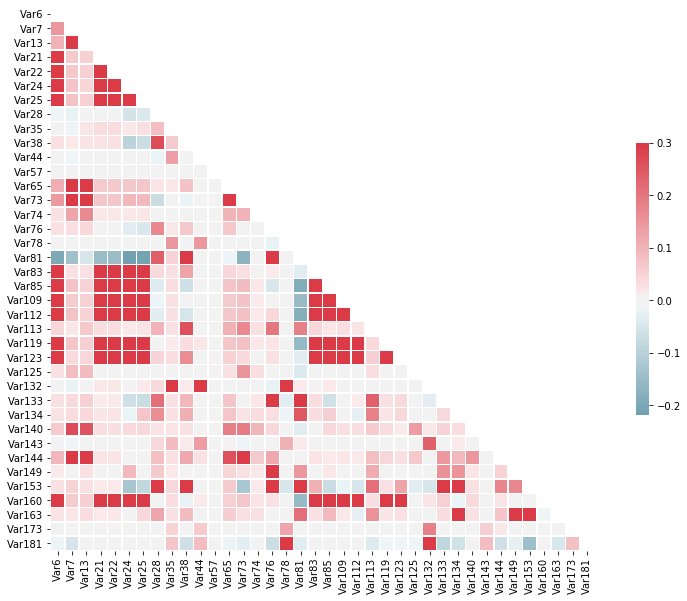

In [38]:
#-- gerando um gráfico de correlação
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

> A correlação entre as variáveis numéricas é baixa

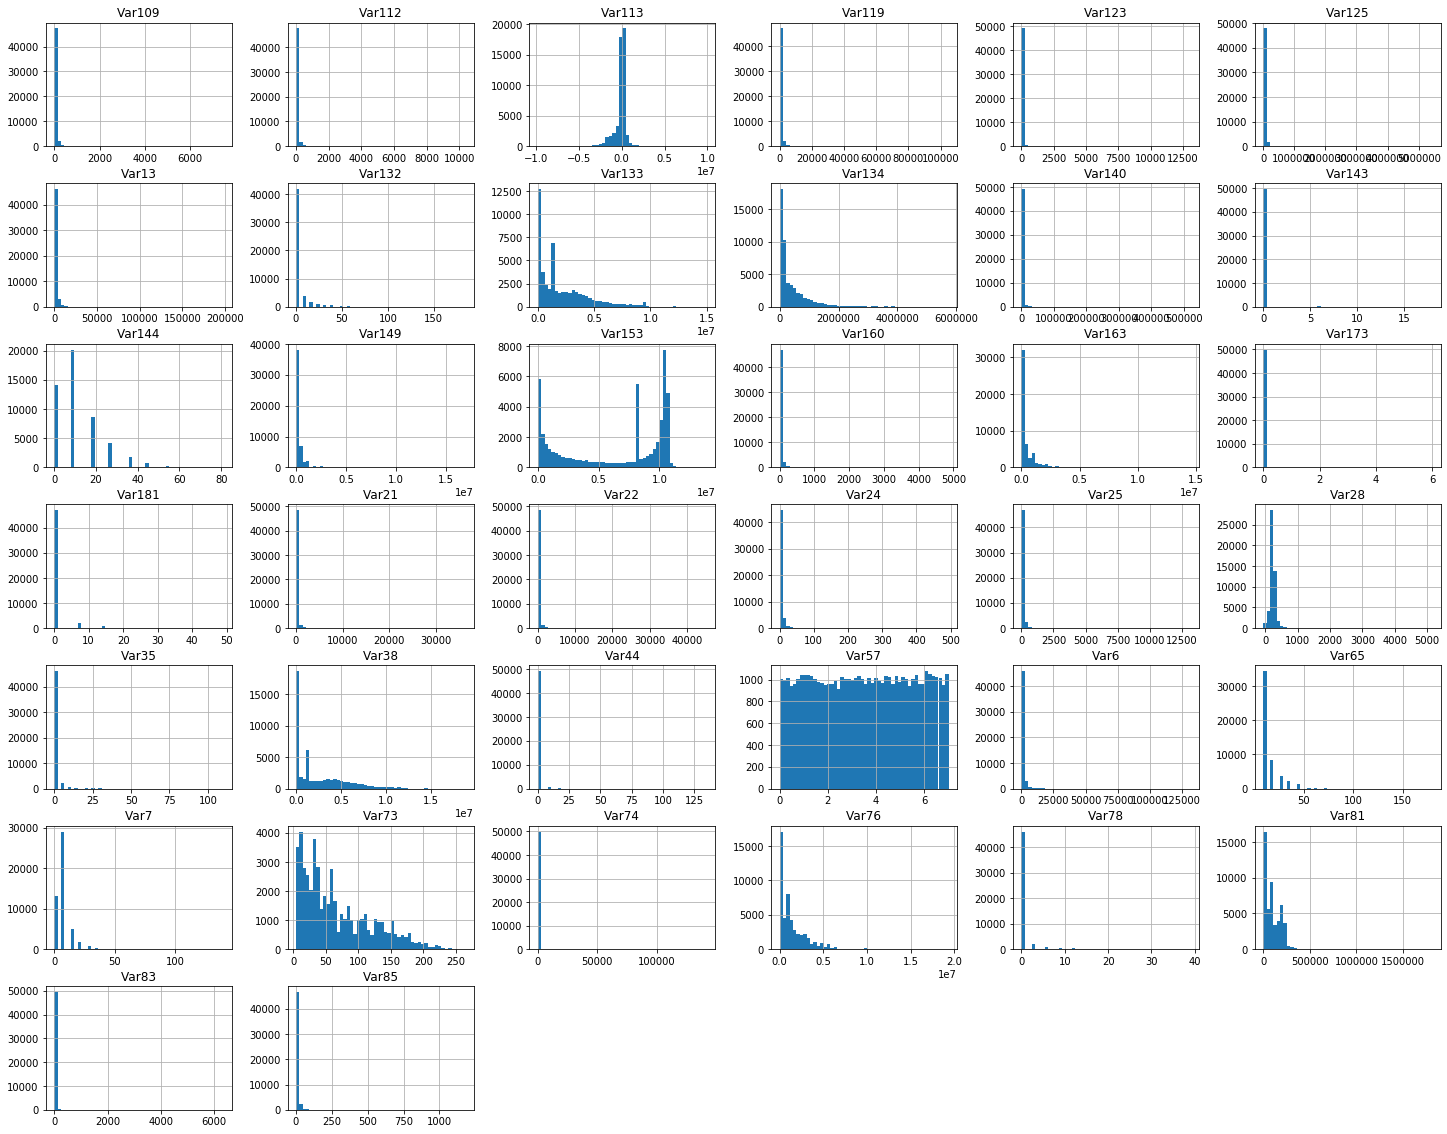

In [39]:
#-- plotando novamente o histograma das features numéricas para verificar as alturações com o preenchimento dos missing values
_ = db_dcol_drow[columns_numeric].hist(bins=50, figsize=(25,20))

In [40]:
#-- padronizando as features numéricas
scaler = StandardScaler()
db_dcol_drow.loc[:,columns_numeric] = scaler.fit_transform(db_dcol_drow.loc[:, columns_numeric])

In [41]:
#-- printando o head do dataset para verificar a padronização das features numéricas
db_dcol_drow.head().T

,0,1,2,3,4
Var6,0.0989469,-0.295609,1.56129,-0.163171,-0.0969517
Var7,0.0283961,-1.145,0.0283961,-1.145,0.0283961
Var13,-0.358946,-0.428253,-0.0877445,-0.428253,0.783113
Var21,0.448382,-0.105797,1.84881,-0.150731,-0.300509
Var22,0.449569,-0.103427,1.847,-0.417289,-0.297722
...,...,...,...,...,...
Var227,RAYp,RAYp,02N6s8f,RAYp,RAYp
Var228,F2FyR07IdsN7I,F2FyR07IdsN7I,ib5G6X1eUxUn6,F2FyR07IdsN7I,F2FyR07IdsN7I
label_churn,-1,1,-1,-1,-1
label_upselling,-1,-1,-1,-1,-1


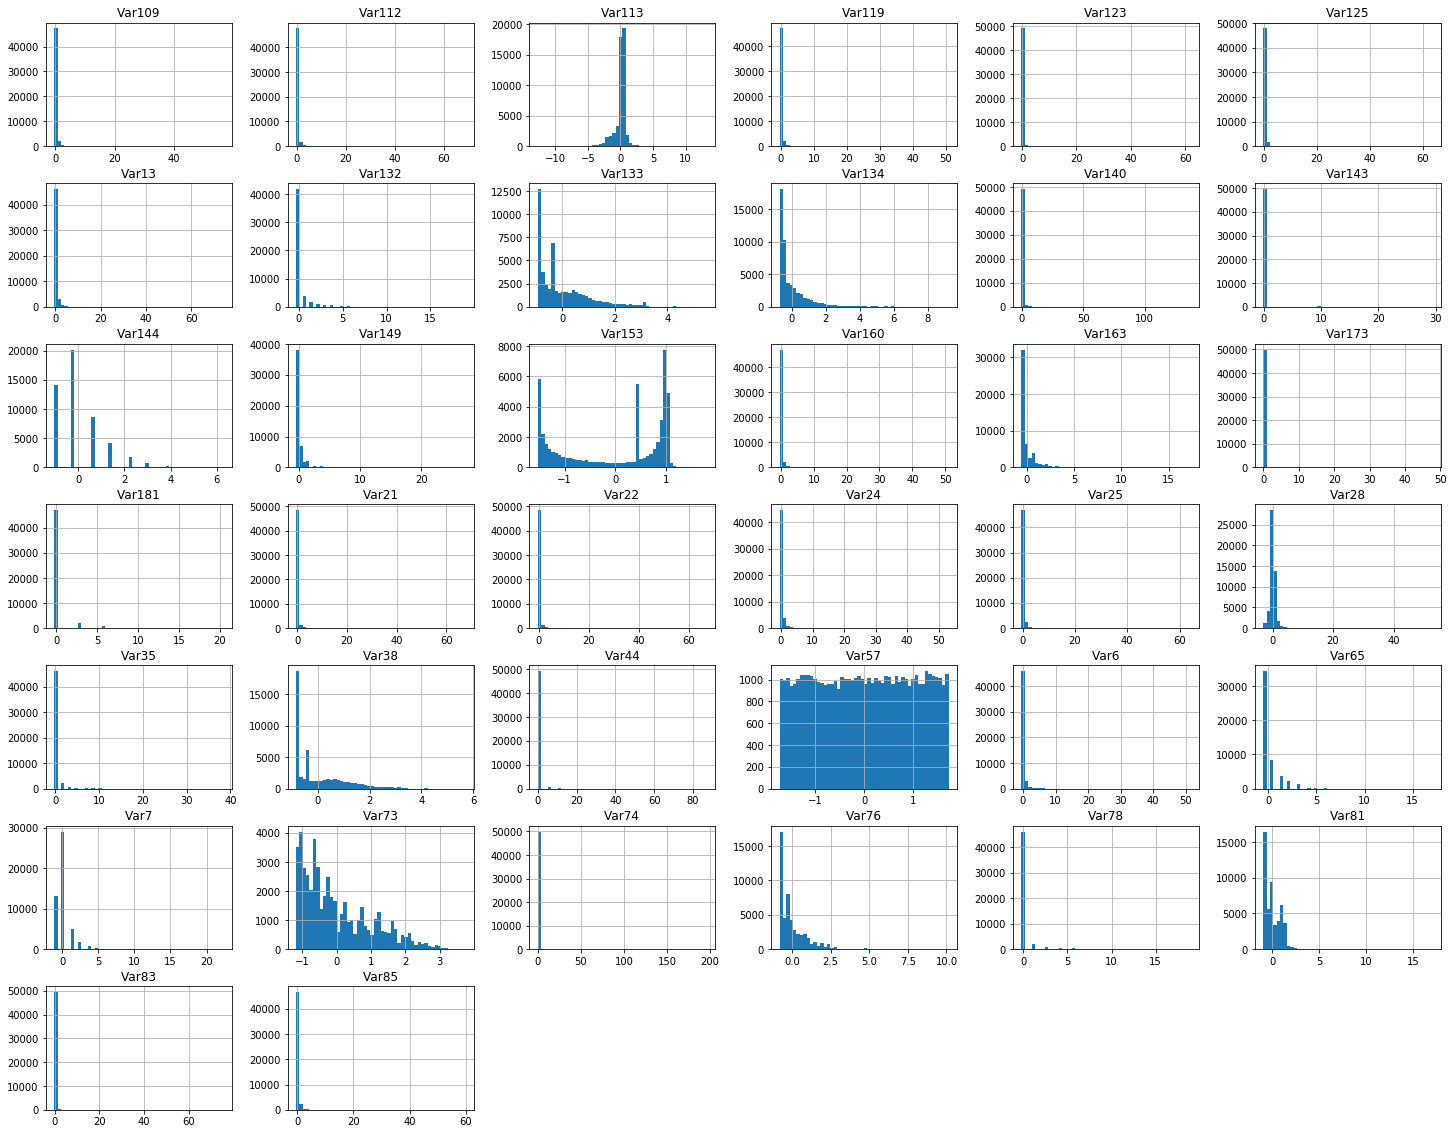

In [42]:
#-- plotando novamente o histograma para verificar a alteração da padronização nas features numéricas
_ = db_dcol_drow[columns_numeric].hist(bins=50, figsize=(25,20))

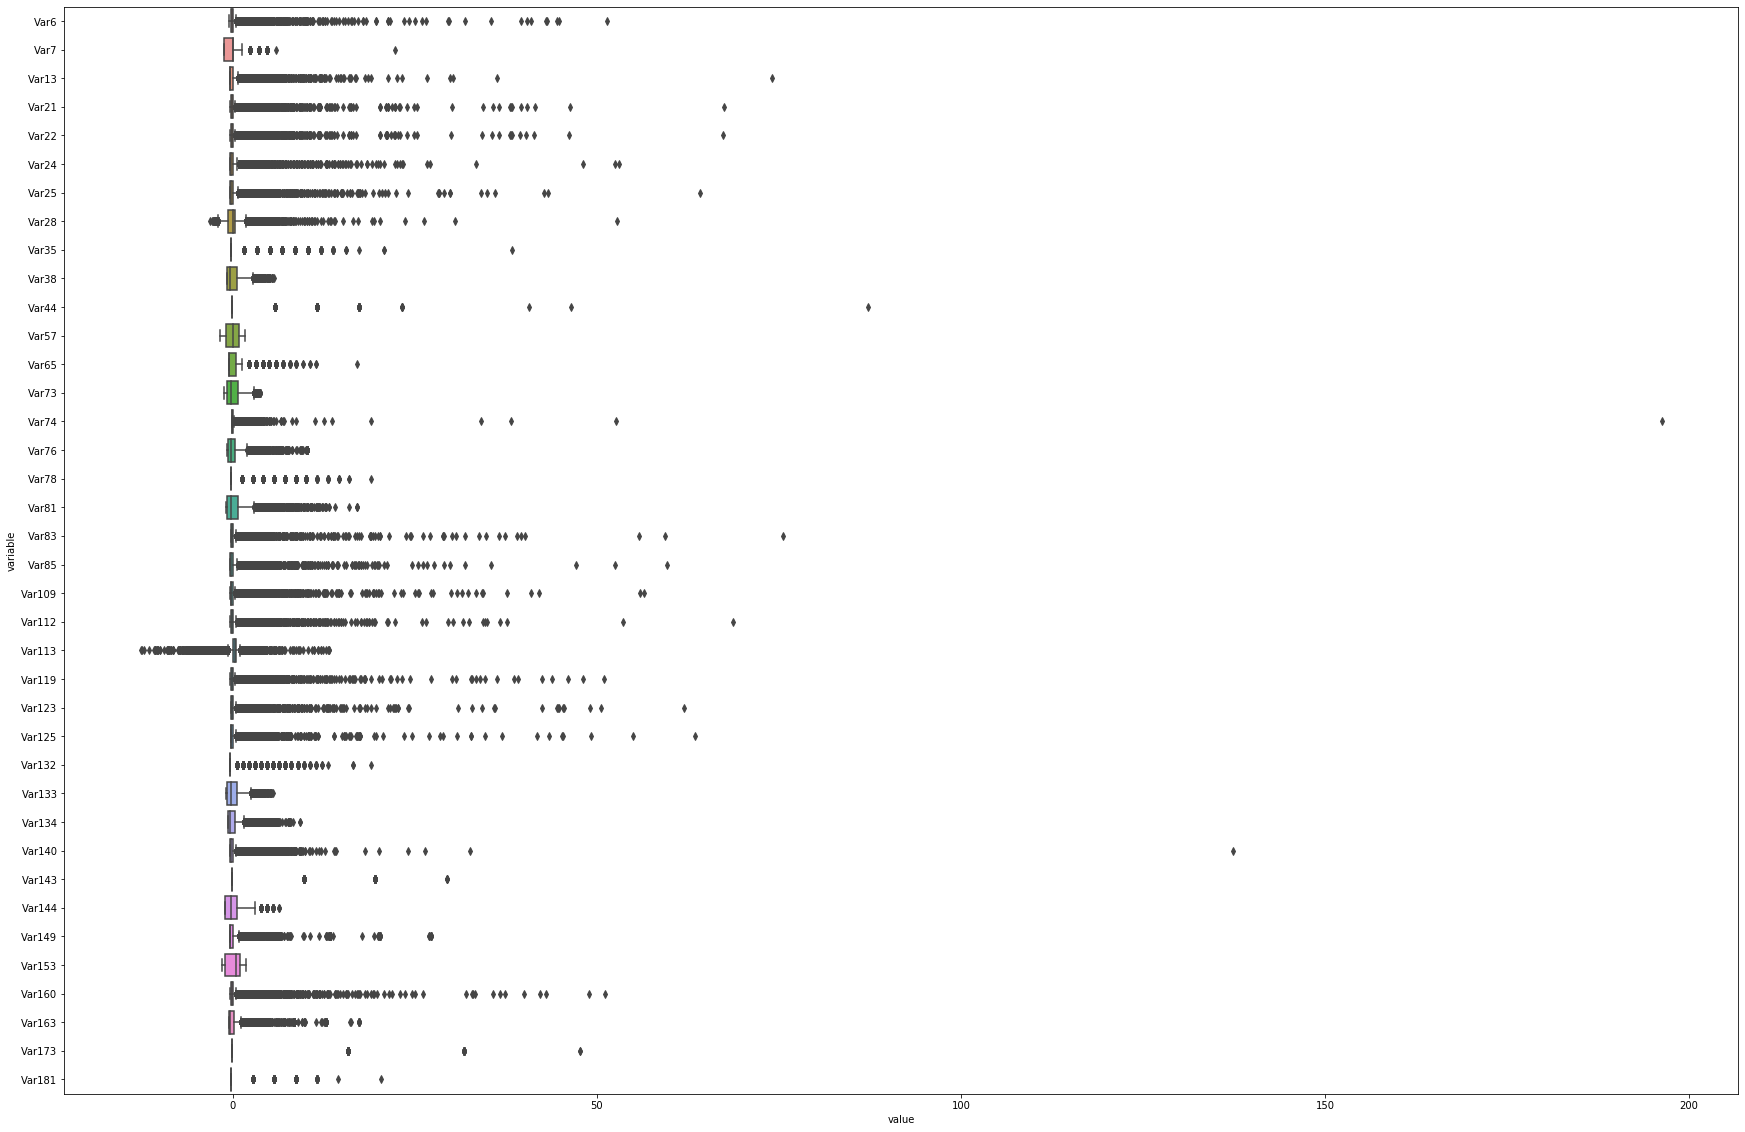

In [43]:
#-- plotando o boxplot para verificar as alterações das features numéricas
plt.figure(figsize=(30,20))
_ = sns.boxplot(x="value", y="variable", data=db_dcol_drow[columns_numeric].melt())

> Apesar de identificar diversos outliers com o gráfico de boxplot, não irei retirá-los nesse momento.

In [44]:
#-- criando uma array com as colunas não numéricas
columns_object2 = db_dcol_drow.select_dtypes(object).columns
columns_object2 = np.array(columns_object2)
columns_object2

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [45]:
#-- preenchendo as features categóricas com missing value - usando a media para isso
imputer_c = SimpleImputer(strategy='constant', fill_value='missing')
imputer_c = imputer_c.fit(db_dcol_drow.loc[:,columns_object2])
db_dcol_drow.loc[:, columns_object2] = imputer_c.transform(db_dcol_drow.loc[:, columns_object2])

In [46]:
#-- verificando se as features numéricas não tem mais nenhum missing value
x_null = db_dcol_drow[columns_object2].isnull()
null_data = pd.DataFrame({
    "count": x_null.sum(),
    "mean": x_null.mean()
})
null_data

,count,mean
Var192,0,0.0
Var193,0,0.0
Var195,0,0.0
Var196,0,0.0
Var197,0,0.0
Var203,0,0.0
Var204,0,0.0
Var205,0,0.0
Var206,0,0.0
Var207,0,0.0


## Transformando as features categóricas em dummies

In [47]:
#-- transformando as features não nméricas em dummies
db_final = pd.get_dummies(db_dcol_drow, prefix=columns_object2, columns=columns_object2)

In [48]:
#-- transformando features numérica categórica em dummy
db_final = pd.get_dummies(db_final, prefix=['Var7', 'Var132', 'Var144','Var181'], columns=['Var7', 'Var132', 'Var144','Var181'])

In [49]:
#-- printando as informações básicas do dataset
db_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 1083 entries, Var6 to Var181_20.404591931836244
dtypes: float64(34), int64(3), uint8(1046)
memory usage: 64.0 MB


# Gerando os datasets para criação dos modelos

In [50]:
#-- criando os dataset para análise
X = db_final.drop(columns=['label_appetency', 'label_churn', 'label_upselling'])
y_appetency = db_final['label_appetency']
y_churn = db_final['label_churn']
y_upselling = db_final['label_upselling']

## Modelo de Churn

In [51]:
#-- criando o balanceamento
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y)

#-- checando
print("tamanho do dataset ",len(os_data_X))
print("número de clientes com cancelamento",len(os_data_y[os_data_y['label_churn']==-1]))
print("número de clientes sem cancelamento",len(os_data_y[os_data_y['label_churn']==1]))
print("proporção de com cancelamento ",len(os_data_y[os_data_y['label_churn']==-1])/len(os_data_X))
print("proporção de sem cancelamento ",len(os_data_y[os_data_y['label_churn']==1])/len(os_data_X))

tamanho do dataset  64912
número de clientes com cancelamento 32456
número de clientes sem cancelamento 32456
proporção de com cancelamento  0.5
proporção de sem cancelamento  0.5


In [52]:
logreg_churn = LogisticRegression(solver='liblinear', random_state=0)

In [53]:
logreg_churn.fit(os_data_X, os_data_y)
y_pred = logreg_churn.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
accuracy_test = accuracy_score(y_test, y_pred)
print(f'accuracy (test): {accuracy_test*100:.1f}%')

accuracy (test): 92.4%


In [55]:
confusion_matrix(y_test, y_pred)

array([[13855,    17],
       [ 1117,    11]], dtype=int64)

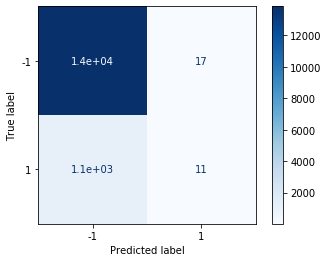

In [56]:
#-- printando a matriz de confusão
_ = plot_confusion_matrix(logreg_churn, X_test, y_test, cmap=plt.cm.Blues)

In [57]:
#-- printando as novas métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96     13872
           1       0.39      0.01      0.02      1128

    accuracy                           0.92     15000
   macro avg       0.66      0.50      0.49     15000
weighted avg       0.89      0.92      0.89     15000



In [58]:
#-- calculando as probabilidades
y_pred_proba = logreg_churn.predict_proba(X_test)
y_pred_proba[:5]

array([[0.9529717 , 0.0470283 ],
       [0.91376808, 0.08623192],
       [0.96925765, 0.03074235],
       [0.97305878, 0.02694122],
       [0.84787729, 0.15212271]])

In [59]:
#-- copiando apenas a coluna de interesse
y_pred_proba = y_pred_proba[:, 1]
y_pred_proba[:5]

array([0.0470283 , 0.08623192, 0.03074235, 0.02694122, 0.15212271])

In [60]:
#-- comparando os valores previstos com os valores reais
preds_df = pd.DataFrame(data=[y_pred, y_test.astype(str)],
                        index=['Prediction', 'True Value']).T

preds_df['Prediction'] = preds_df['Prediction'].astype(float)
preds_df['True Value'] = preds_df['True Value'].astype(str)

preds_df.head(50)

,Prediction,True Value
0,-1.0,1
1,-1.0,-1
2,-1.0,-1
3,-1.0,-1
4,-1.0,-1
5,-1.0,-1
6,-1.0,-1
7,-1.0,-1
8,-1.0,-1
9,-1.0,-1


In [61]:
#-- calculando o AUC do modelo
print(f'auc (test): {roc_auc_score(y_test, y_pred):.4f}')

auc (test): 0.5043


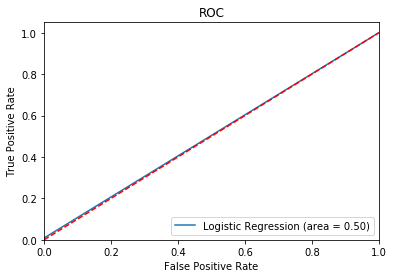

In [62]:
#-- plotando a ROC
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

> Quanto maior o valor da curva ROC melhor, neste caso o valor é de 0,58. O que pode ser melhorado.

In [63]:
#-- transformando os valores de y_test em falso ou verdadeiro
for i in range (0, len(y_test)):
    if y_test.iloc[i] == -1:
        y_test.iloc[i] = 0
    else:
        y_test.iloc[i] = 1

In [64]:
#-- criando uma linha de corte para o y_pred_customizado
y_pred_customizado = pd.DataFrame()
for i in range(0, 90, 5):
    y_pred_customizado[i] = y_pred_proba >= i/100
    print(f'auc (test): {roc_auc_score(y_test, y_pred_customizado[i]):.4f}')

auc (test): 0.5000
auc (test): 0.5854
auc (test): 0.5960
auc (test): 0.5709
auc (test): 0.5519
auc (test): 0.5335
auc (test): 0.5207
auc (test): 0.5163
auc (test): 0.5115
auc (test): 0.5048
auc (test): 0.5043
auc (test): 0.5036
auc (test): 0.5029
auc (test): 0.5012
auc (test): 0.5009
auc (test): 0.5004
auc (test): 0.5004
auc (test): 0.5000


In [65]:
#-- encontrando o valor máximo da roc
roc_max=[]
for i in range(0,90,5):
    roc_max.append(roc_auc_score(y_test, y_pred_customizado[i]))

In [66]:
#-- imprimindo a porcentagem de corte
roc_max.index(np.max(roc_max))

2

In [67]:
#-- pritando o valor máximo ra roc
y_pred_customizado_max = y_pred_proba >= (roc_max.index(np.max(roc_max))*5)/100
print(f'auc (test): {roc_auc_score(y_test, y_pred_customizado_max):.4f}')

auc (test): 0.5960


In [68]:
#- transformando o y_pred_customizado em dataframe
y_pred_customizado_max = pd.DataFrame(y_pred_customizado_max)
y_pred_customizado_max.head()

,0
0,False
1,False
2,False
3,False
4,True


In [69]:
#-- calculando a matriz de confusão do modelo
confusion_matrix(y_test, y_pred_customizado_max)

array([[10190,  3682],
       [  612,   516]], dtype=int64)

In [70]:
#-- calculando o y predito com a amostra de treino
y_pred_train = logreg_churn.predict(X_train)

In [71]:
#-- comparando a auc de treino com a de teste
print(f'auc (train): {roc_auc_score(y_train, y_pred_train):.4f}')
print(f'auc (test): {roc_auc_score(y_test, y_pred):.4f}')

auc (train): 0.5092
auc (test): 0.5043


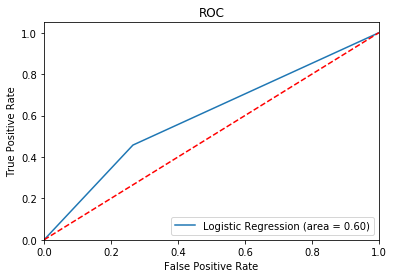

In [72]:
#-- plotando a ROC
logit_roc_auc = roc_auc_score(y_test, y_pred_customizado_max)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_customizado_max)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

> Existe uma diferença entre a aux de treino com a de teste. Pela proporação apresentado, isso indica um overfitting do modelo, ou seja, o modelo está mais adaptado a amostra de treino que a amostra de teste. Alguns ajustes nos dados como a remoção dos outliers poderia reduzir esse efeito. Identificar as features mais importantes para o modelo também. No entanto, por questões de tempo, uma auc de 0.59 é satisfatória.

# Conclusão

> Os resultados dos modelos são satisfatórios se for levado em consideração que foram os primeiros modelos gerado e em menos de uma semana.

> Eles podem ser melhorados, mas para isso precisaríamos de mais tempo.

> Ficam aqui as considerações para os próximos estudos:
1. Analisar os outliers
2. Tentar encontrar os dados faltantes
3. Melhorar a coleta de dados
4. Tentar adquirir mais dados no mercado
5. Testar outros modelos de machine learning